In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/opt/conda/bin/python
3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)


In [3]:
# !sudo apt-get update
# !sudo apt-get install -y xvfb ffmpeg freeglut3-dev
# !pip install -q 'gym==0.16.0'
# !pip install 'imageio==2.4.0'
# !pip install pyvirtualdisplay
# !pip install tf-agents[reverb]
# !pip install pyglet
# !pip install ale-py

In [4]:
!pip install imageio

In [5]:
# !wget http://www.atarimania.com/roms/Roms.rar
# !pip install unrar
# !unrar x Roms.rar
# !mkdir rars
# !mv HC\ ROMS.zip  rars
# !mv ROMS.zip  rars
# !python -m atari_py.import_roms rars

In [6]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
# import reverb

import gym
import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.environments import suite_gym, suite_atari
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential, q_network, network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import TFUniformReplayBuffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

2022-12-04 23:38:00.149723: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 23:38:00.316829: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-04 23:38:01.075164: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-12-04 23:38:01.075279: W tensorflow/stream_executor/platform/default/dso_l

In [7]:
gym.__version__

'0.21.0'

In [8]:
# list available environments
print(gym.envs.registry.all())

dict_values([EnvSpec(ALE/Tetris-v5), EnvSpec(ALE/Tetris-ram-v5), EnvSpec(ALE/Darkchambers-v5), EnvSpec(ALE/Darkchambers-ram-v5), EnvSpec(ALE/RoadRunner-v5), EnvSpec(ALE/RoadRunner-ram-v5), EnvSpec(ALE/Hero-v5), EnvSpec(ALE/Hero-ram-v5), EnvSpec(ALE/BattleZone-v5), EnvSpec(ALE/BattleZone-ram-v5), EnvSpec(ALE/Pitfall2-v5), EnvSpec(ALE/Pitfall2-ram-v5), EnvSpec(ALE/UpNDown-v5), EnvSpec(ALE/UpNDown-ram-v5), EnvSpec(ALE/SpaceWar-v5), EnvSpec(ALE/SpaceWar-ram-v5), EnvSpec(ALE/Entombed-v5), EnvSpec(ALE/Entombed-ram-v5), EnvSpec(ALE/Koolaid-v5), EnvSpec(ALE/Koolaid-ram-v5), EnvSpec(ALE/Phoenix-v5), EnvSpec(ALE/Phoenix-ram-v5), EnvSpec(ALE/Robotank-v5), EnvSpec(ALE/Robotank-ram-v5), EnvSpec(ALE/BasicMath-v5), EnvSpec(ALE/BasicMath-ram-v5), EnvSpec(ALE/Pacman-v5), EnvSpec(ALE/Pacman-ram-v5), EnvSpec(ALE/Amidar-v5), EnvSpec(ALE/Amidar-ram-v5), EnvSpec(ALE/Kangaroo-v5), EnvSpec(ALE/Kangaroo-ram-v5), EnvSpec(ALE/ChopperCommand-v5), EnvSpec(ALE/ChopperCommand-ram-v5), EnvSpec(ALE/ElevatorAction-v5),

In [9]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
     

In [10]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  '''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30, max_steps=-1):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      n_step = 0
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
        n_step += 1
        if (n_step > max_steps) & (max_steps > 0):
          break
  return embed_mp4(filename)

In [11]:
#env_name = 'BreakoutNoFrameskip-v4'
env_name = 'SpaceInvaders-v0'
env = suite_gym.load(env_name)

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


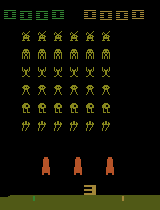

In [12]:

env.reset()
PIL.Image.fromarray(env.render())
     

In [13]:
print('Observation Spec:')
print(env.time_step_spec().observation)
     

Observation Spec:
BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)


In [14]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [15]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=5)


In [16]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [17]:
time_step = env.reset()
print('Time step:')
print(time_step.observation.shape)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step.observation.shape)

Time step:
(210, 160, 3)
Next time step:
(210, 160, 3)


In [18]:
ATARI_FRAME_SKIP = 4
max_episode_frames = ATARI_FRAME_SKIP * 50_000

train_py_env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)
eval_py_env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [19]:

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())
  

In [20]:
!pip install imageio[ffmpeg]
!pip install imageio[pyav]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 30.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 25.9 MB/s eta 0:00:0000:0100:01


In [20]:

create_policy_eval_video(random_policy, "random-agent", num_episodes=1)
     

2022-12-04 23:38:44.165198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 23:38:44.290733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 23:38:44.292493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 23:38:44.299113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [21]:
train_py_env.observation_spec().shape     

(84, 84, 4)

In [22]:
# https://keras.io/examples/rl/deep_q_network_breakout/
# Define a Q network with three convolutional layers and a fully connected layer
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1
observation_spec = tensor_spec.from_spec(train_env.observation_spec())    # (84, 84, 4) four gray frames stacking       

# preprocessing from uint8 color code between 0 and 255 to a float32 between 0 and 1.
layer0 = tf.keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32) / 255.)
layer1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(8, 8), strides = (4, 4), activation='relu')
layer2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(4, 4), strides = (2, 2), activation='relu')
layer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides = (1, 1), activation='relu')
layer4 = tf.keras.layers.Flatten()
layer5 = tf.keras.layers.Dense(512, activation='relu')
layer6 = tf.keras.layers.Dense(num_actions, activation='linear') # action layer

q_net = sequential.Sequential([layer0, layer1, layer2, layer3, layer4, layer5, layer6])
     

In [23]:
q_net.build(input_shape=observation_spec.shape)
q_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              multiple                  0 (unused)
_________________________________________________________________
conv2d (Conv2D)              multiple                  0 (unused)
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  0 (unused)
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  0 (unused)
_________________________________________________________________
flatten (Flatten)            multiple                  0 (unused)
_________________________________________________________________
dense (Dense)                multiple                  0 (unused)
_________________________________________________________________
dense_1 (Dense)              multiple                  0

In [24]:
global_step = tf.compat.v1.train.get_or_create_global_step()
#train_step = tf.Variable(0)
update_period = 4 # train the model every 4 steps
optimizer = tf.keras.optimizers.RMSprop(lr=2.5e-4, rho=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True)
epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ε
    decay_steps=250000 // update_period, # <=> 1,000,000 ALE frames
    end_learning_rate=0.01) # final ε
agent = dqn_agent.DqnAgent(train_env.time_step_spec(),
                           train_env.action_spec(),
                           q_network=q_net,
                           optimizer=optimizer,
                           target_update_period=2000, # <=> 32,000 ALE frames
                           td_errors_loss_fn=tf.keras.losses.Huber(reduction="none"),
                           gamma=0.99, # discount factor
                           train_step_counter=global_step,
                           epsilon_greedy=lambda: epsilon_fn(global_step))
agent.initialize()
     

2022-12-04 23:39:15.950060: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


In [25]:
def compute_avg_return(environment, policy, num_episodes=10, max_steps=-1):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    n_step = 0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
      n_step += 1
      if (n_step > max_steps) & (max_steps > 0):
        break
    
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]
     

In [26]:
num_eval_episodes = 5
compute_avg_return(eval_env, random_policy, num_eval_episodes)

177.0

In [27]:
replay_buffer = TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=9000)

2022-12-04 23:39:40.637717: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 254016000 exceeds 10% of free system memory.


In [28]:
replay_buffer_observer = replay_buffer.add_batch

In [ ]:
train_env.reset()

init_driver = DynamicStepDriver(
    train_env,
    random_policy,
    observers=[replay_buffer.add_batch],
    num_steps=20_000) # <=> 80,000 ALE frames
final_time_step, final_policy_state = init_driver.run()

In [31]:

trajectories, buffer_info = replay_buffer.get_next(sample_batch_size=2, num_steps=3)
     

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [32]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

In [33]:
from tf_agents.trajectories.trajectory import to_transition
time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 2, 84, 84, 4])

In [34]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=32,
    num_steps=2).prefetch(3)

In [35]:

iterator = iter(dataset)
     

In [36]:

num_iterations = 100_000   # less intelligence, more persistance; 24x7 player
save_interval = 100_000
eval_interval = 50_000
log_interval = 5_000
     

In [37]:

# Create a driver to collect experience.
collect_driver = DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=[replay_buffer_observer],
    num_steps=update_period) # collect 4 steps for each training iteration
     

In [38]:

#from tf_agents.policies import PolicySaver
import os
import io
import tempfile
import shutil
import zipfile
import numpy as np
# from google.colab import files

tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())

In [39]:
def create_zip_file(dirname, base_filename):
  return shutil.make_archive(base_filename, 'zip', dirname)

def save_checkpoint_to_local():
  train_checkpointer.save(global_step)
  # add returns to checkpoint_dir
  np.savetxt(os.path.join(checkpoint_dir, 'returns.txt'), returns, delimiter=',')
  checkpoint_zip_filename = create_zip_file(checkpoint_dir, os.path.join(tempdir, 'exported_cp'))
  # Privacy and security -> Site Settings -> Automatic downloads
  files.download(checkpoint_zip_filename) # try again if this fails: https://github.com/googlecolab/colabtools/issues/469

def upload_and_unzip_file_to(dirname):
  if files is None:
    return
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    shutil.rmtree(dirname)
    zip_files = zipfile.ZipFile(io.BytesIO(uploaded[fn]), 'r')
    zip_files.extractall(dirname)
    zip_files.close()
     

In [40]:

checkpoint_dir = os.path.join(tempdir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)
     

In [ ]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
collect_driver.run = common.function(collect_driver.run)
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = np.array([avg_return])

# Reset the environment.
time_step = None
policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)

step = 0
while True:
    # Collect a few steps using collect_policy and save to the replay buffer.
    time_step, policy_state = collect_driver.run(time_step, policy_state)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()
    print(f'\r step {step}', end='')

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns = np.append(returns, avg_return)

    # if step % save_interval == 0:
    #     save_checkpoint_to_local()

    if step > num_iterations:
        break
        
        

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


 step 353

In [ ]:
save_checkpoint_to_local()
     

In [ ]:
!mkdir -p $checkpoint_dir

In [ ]:

upload_and_unzip_file_to(checkpoint_dir)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()
returns = np.loadtxt(os.path.join(checkpoint_dir, 'returns.txt'), delimiter=',', dtype=np.float32)
  

In [ ]:

!rm exported_cp.zip
     

In [ ]:

num_iterations = 200_000  



In [ ]:
while True:
    # Collect a few steps using collect_policy and save to the replay buffer.
    time_step, policy_state = collect_driver.run(time_step, policy_state)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()
    print(f'\r step {step}', end='')

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns = np.append(returns, avg_return)

    # if step % save_interval == 0:
    #     save_checkpoint_to_local()

    if step > num_iterations:
        break
     

In [ ]:

save_checkpoint_to_local()

In [ ]:
from tf_agents.policies import policy_saver

policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

tf_policy_saver.save(policy_dir)
policy_zip_filename = create_zip_file(policy_dir, os.path.join(tempdir, 'exported_policy'))
     

In [ ]:
files.download(policy_zip_filename)

In [ ]:

# upload_and_unzip_file_to(policy_dir)       # wget from github and unzip
# saved_policy = tf.saved_model.load(policy_dir)
     

In [ ]:

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=550)

In [ ]:

create_policy_eval_video(agent.policy, "trained-agent", num_episodes=1)
     